In [95]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr, kendalltau
import numpy as np

# Data Analysis

### Awards Player

In [96]:
awards_players_dataSet = pd.read_csv('../Other/basketballPlayoffs/awards_players.csv')
#print(awards_players_dataSet.info())
columns_to_remove = ['lgID']
awards_players_new = awards_players_dataSet.drop(columns=columns_to_remove)

awards_players_new = awards_players_new[(awards_players_new['award'] != 'Kim Perrot Sportsmanship Award') & (awards_players_new['award'] != 'Sixth Woman of the Year') ]

awards_players_new.to_csv('newDataset/awards_players_cleaned.csv', index=False)

### Coaches

In [97]:
coaches_dataSet = pd.read_csv('../Other/basketballPlayoffs/coaches.csv')
#print(coaches_dataSet.info())

#Check if stint could be removed
columns_to_remove = ['lgID']
coaches_new = coaches_dataSet.drop(columns=columns_to_remove)

coaches_new.to_csv('newDataset/coaches_cleaned.csv', index=False)

### Players

In [98]:
players_dataSet = pd.read_csv('../Other/basketballPlayoffs/players.csv')
#print(players_dataSet.info())

#Maybe everything is usless
columns_to_remove = ['firstseason', 'lastseason', 'college', 'collegeOther', 'deathDate']
players_dataSet_new = players_dataSet.drop(columns=columns_to_remove)

players_dataSet.to_csv('newDataset/players_cleaned.csv', index=False)

### Players Teams

In [99]:
players_teams_dataSet = pd.read_csv('../Other/basketballPlayoffs/players_teams.csv')
#print(players_teams_dataSet.info())

#Check if something else could be removed
columns_to_remove = ['lgID', 'turnovers']
players_teams_new = players_teams_dataSet.drop(columns=columns_to_remove)

players_teams_new.to_csv('newDataset/players_teams_cleaned.csv', index=False)

### Series Post

In [100]:
series_post_dataSet = pd.read_csv('../Other/basketballPlayoffs/series_post.csv')
#print(series_post_dataSet.info())

#Check if something else could be removed
columns_to_remove = ['lgIDWinner', 'lgIDLoser']
series_post_new = series_post_dataSet.drop(columns=columns_to_remove)

series_post_new.to_csv('newDataset/series_post_cleaned.csv', index=False)

### Teams

In [101]:
teams_dataSet = pd.read_csv('../Other/basketballPlayoffs/teams.csv')
#print(teams_dataSet.info()) 
columns_to_remove = ['lgID','divID', 'seeded', 'tmORB', 'tmDRB', 'tmTRB', 'opptmORB', 'opptmDRB', 'opptmTRB', 'homeW','homeL', 'awayW', 'awayL', 'confW','confL', 'min', 'attend', 'arena'] 
teams_new = teams_dataSet.drop(columns=columns_to_remove)
teams_new.to_csv('newDataset/teams_cleaned.csv', index=False)

In [102]:
#add the column winrate
df = pd.read_csv('newDataset/teams_cleaned.csv')

df['winrate'] =  df['won'] / df['GP'] * 100
df.to_csv('newDataset/teams_cleaned.csv', index=False)

remove = ['won', 'lost']
df = df.drop(columns=remove)
df.to_csv('newDataset/teams_cleaned.csv', index=False)

In [103]:
#mismatches goals made, ordered by year
df_teams = pd.read_csv('newDataset/teams_cleaned.csv')
df_players = pd.read_csv('newDataset/players_teams_cleaned.csv')

# sum  of fieldGoals group by team from "players_teams"
sum_fieldGoals = df_players.groupby(['tmID', 'year'])['fgMade'].sum().reset_index()
sum_fieldGoals.rename(columns={'fgMade': 'sum_fgMadePlayer'}, inplace=True)
# add sum to teams to merge
df_compare = pd.merge(df_teams, sum_fieldGoals, on=['tmID', 'year'], how='left')

# difference between total on teams and total on sum players
df_compare['diff_fieldGoals'] = df_compare['o_fgm'] - df_compare['sum_fgMadePlayer']
# find mismatch in rows
mismatch = df_compare[df_compare['diff_fieldGoals'] != 0]
first_year = mismatch['year'].min()
# new dataframe for all the mismatch
all_mismatches = pd.DataFrame()

# for all the 10 years
for year in range(first_year, first_year + 10):
    mismatch_specific_year = mismatch[mismatch['year'] == year]
    
    # print mismatch specific year 
    print(mismatch_specific_year)
    print("\n" + "-" * 50 + "\n")
    
    # add to dataframe
    all_mismatches = pd.concat([all_mismatches, mismatch_specific_year], ignore_index=True)

# save all in .csv
all_mismatches.to_csv('allmismatch_fieldGoals.csv', index=False)


    year tmID franchID confID  rank playoff firstRound semis finals  \
67     2  MIN      MIN     WE     6       N        NaN   NaN    NaN   

              name  ...  d_asts  d_pf  d_stl  d_to  d_blk  d_pts  GP  winrate  \
67  Minnesota Lynx  ...     511   719    259   470    126   2156  32     37.5   

    sum_fgMadePlayer  diff_fieldGoals  
67               607               64  

[1 rows x 44 columns]

--------------------------------------------------

    year tmID franchID confID  rank playoff firstRound semis finals  \
4      3  CHA      CHA     EA     2       Y          L   NaN    NaN   
68     3  MIN      MIN     WE     8       N        NaN   NaN    NaN   

               name  ...  d_asts  d_pf  d_stl  d_to  d_blk  d_pts  GP  \
4   Charlotte Sting  ...     489   600    208   424    103   2133  32   
68   Minnesota Lynx  ...     495   618    273   465    117   2104  32   

    winrate  sum_fgMadePlayer  diff_fieldGoals  
4     56.25               737               33  
68    

In [104]:
#mismatches free throws made, ordered by year
df_teams = pd.read_csv('newDataset/teams_cleaned.csv')
df_players = pd.read_csv('newDataset/players_teams_cleaned.csv')

# sum  of fieldGoals group by team from "players_teams"
sum_freeThrows = df_players.groupby(['tmID', 'year'])['ftMade'].sum().reset_index()
sum_freeThrows.rename(columns={'ftMade': 'sum_ftMadePlayer'}, inplace=True)
# add sum to teams to merge
df_compare = pd.merge(df_teams, sum_freeThrows, on=['tmID', 'year'], how='left')

# difference between total on teams and total on sum players
df_compare['diff_freeThrows'] = df_compare['o_ftm'] - df_compare['sum_ftMadePlayer']
# find mismatch in rows
mismatch = df_compare[df_compare['diff_freeThrows'] != 0]
first_year = mismatch['year'].min()
# new dataframe for all the mismatch
all_mismatches = pd.DataFrame()

# for all the 10 years
for year in range(first_year, first_year + 10):
    mismatch_specific_year = mismatch[mismatch['year'] == year]
    
    # print mismatch specific year 
    print(mismatch_specific_year)
    print("\n" + "-" * 50 + "\n")
    
    # add to dataframe
    all_mismatches = pd.concat([all_mismatches, mismatch_specific_year], ignore_index=True)

# save all in .csv
all_mismatches.to_csv('allmismatch_freeThrows.csv', index=False)


    year tmID franchID confID  rank playoff firstRound semis finals  \
67     2  MIN      MIN     WE     6       N        NaN   NaN    NaN   

              name  ...  d_asts  d_pf  d_stl  d_to  d_blk  d_pts  GP  winrate  \
67  Minnesota Lynx  ...     511   719    259   470    126   2156  32     37.5   

    sum_ftMadePlayer  diff_freeThrows  
67               512               47  

[1 rows x 44 columns]

--------------------------------------------------

    year tmID franchID confID  rank playoff firstRound semis finals  \
4      3  CHA      CHA     EA     2       Y          L   NaN    NaN   
68     3  MIN      MIN     WE     8       N        NaN   NaN    NaN   

               name  ...  d_asts  d_pf  d_stl  d_to  d_blk  d_pts  GP  \
4   Charlotte Sting  ...     489   600    208   424    103   2133  32   
68   Minnesota Lynx  ...     495   618    273   465    117   2104  32   

    winrate  sum_ftMadePlayer  diff_freeThrows  
4     56.25               465               25  
68    

In [105]:
#mismatches three-pointers made, ordered by year
df_teams = pd.read_csv('newDataset/teams_cleaned.csv')
df_players = pd.read_csv('newDataset/players_teams_cleaned.csv')

# sum  of fieldGoals group by team from "players_teams"
sum_freeThrows = df_players.groupby(['tmID', 'year'])['threeMade'].sum().reset_index()
sum_freeThrows.rename(columns={'threeMade': 'sum_threeMadePlayer'}, inplace=True)
# add sum to teams to merge
df_compare = pd.merge(df_teams, sum_freeThrows, on=['tmID', 'year'], how='left')

# difference between total on teams and total on sum players
df_compare['diff_threePointers'] = df_compare['o_3pm'] - df_compare['sum_threeMadePlayer']
# find mismatch in rows
mismatch = df_compare[df_compare['diff_threePointers'] != 0]
first_year = mismatch['year'].min()
# new dataframe for all the mismatch
all_mismatches = pd.DataFrame()

# for all the 10 years
for year in range(first_year, first_year + 10):
    mismatch_specific_year = mismatch[mismatch['year'] == year]
    
    # print mismatch specific year 
    print(mismatch_specific_year)
    print("\n" + "-" * 50 + "\n")
    
    # add to dataframe
    all_mismatches = pd.concat([all_mismatches, mismatch_specific_year], ignore_index=True)

# save all in .csv
all_mismatches.to_csv('allmismatch_freeThrows.csv', index=False)

    year tmID franchID confID  rank playoff firstRound semis finals  \
67     2  MIN      MIN     WE     6       N        NaN   NaN    NaN   

              name  ...  d_asts  d_pf  d_stl  d_to  d_blk  d_pts  GP  winrate  \
67  Minnesota Lynx  ...     511   719    259   470    126   2156  32     37.5   

    sum_threeMadePlayer  diff_threePointers  
67                  168                   8  

[1 rows x 44 columns]

--------------------------------------------------

    year tmID franchID confID  rank playoff firstRound semis finals  \
4      3  CHA      CHA     EA     2       Y          L   NaN    NaN   
68     3  MIN      MIN     WE     8       N        NaN   NaN    NaN   

               name  ...  d_asts  d_pf  d_stl  d_to  d_blk  d_pts  GP  \
4   Charlotte Sting  ...     489   600    208   424    103   2133  32   
68   Minnesota Lynx  ...     495   618    273   465    117   2104  32   

    winrate  sum_threeMadePlayer  diff_threePointers  
4     56.25                  207     

### Teams Posts

In [106]:
# Nothing to do for now
teams_post_dataSet = pd.read_csv('../Other/basketballPlayoffs/teams_post.csv')
columns_to_remove = [] 
teams_post_new = teams_post_dataSet.drop(columns=columns_to_remove)
teams_post_new.to_csv('newDataset/teams_post.csv', index=False)

## Correlations


Risultati per ogni premio:
                                    award  Rank_1_Percentage
0                      Rookie of the Year              100.0
1        WNBA Finals Most Valuable Player              100.0
2                    Most Improved Player              100.0
3                    WNBA All-Decade Team              100.0
4            Defensive Player of the Year              100.0
5      All-Star Game Most Valuable Player              100.0
6                    Most Valuable Player              100.0
7  WNBA All Decade Team Honorable Mention              100.0
8                Kim Perrot Sportsmanship              100.0
9                       Coach of the Year              100.0


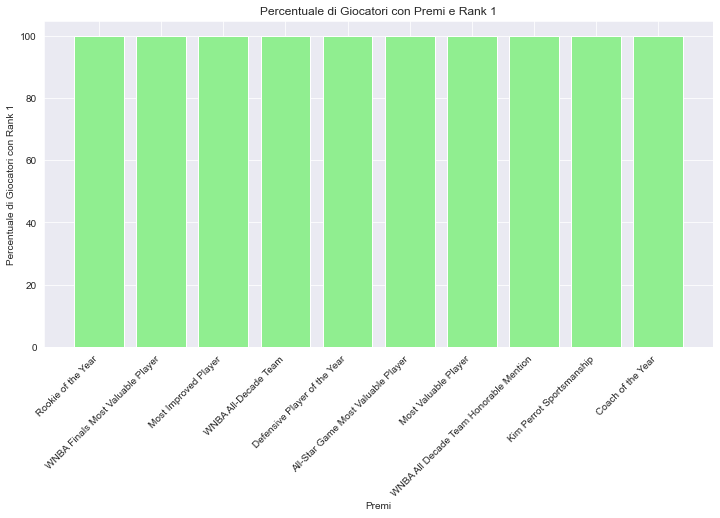

In [119]:
awards_players_df = pd.read_csv('newDataset/awards_players_cleaned.csv')
players_team_df = pd.read_csv('newDataset/players_teams_cleaned.csv')
teams_df = pd.read_csv('newDataset/teams_cleaned.csv')

merged_teams = pd.merge(players_team_df, teams_df, on='tmID', how='inner')
final_df = pd.merge(merged_teams, awards_players_df, on=['playerID'], how='inner')


awards_array = final_df['award'].unique()
results = []

for award in awards_array:
    
    award_df = final_df[final_df['award'] == award]

    rank_1_count = award_df[(award_df['rank'] == 1)].shape[0] 
    total_count = award_df.shape[0]  

    if total_count > 0:
        rank_1_percentage = (rank_1_count / total_count) * 100
    else:
        rank_1_percentage = 0

    results.append({'award': award, 'Rank_1_Percentage': rank_1_percentage})

results_df = pd.DataFrame(results)

print("\nResults for each award:")
print(results_df)

# 9. Visualizzazione della percentuale in un grafico a barre
plt.figure(figsize=(12, 6))
plt.bar(results_df['award'], results_df['Rank_1_Percentage'], color='lightgreen')
plt.title('Percentage of players with players and Rank=1')
plt.xlabel('Awards')
plt.ylabel('Percentage of players with Rank=1')
plt.xticks(rotation=45, ha='right')
plt.show()

